# Tunisian Olive Oil Production Analysis & Prediction
# Based on FAO Tunisia Olive Sector Analysis

Enhanced Tunisian Olive Oil Production Cost Prediction System

1. LOADING DATASET WITH COST INFORMATION
--------------------------------------------------
Dataset shape: (5000, 42)
Date range: 2021-01-01 00:00:00 to 2023-12-30 00:00:00
Missing values: 0
✅ All cost columns found!

2. COST DATA EXPLORATION
----------------------------------------
Cost Column Statistics (TND - Tunisian Dinars):
       Electricity_Cost_TND  Water_Cost_TND  Total_Labor_Cost_TND  \
count           5000.000000     5000.000000           5000.000000   
mean             543.736438        7.233629            571.946223   
std              335.698850        5.071219            691.560665   
min               11.558000        0.140000              7.500000   
25%              297.105500        3.523500            178.665500   
50%              466.725500        5.927500            347.292000   
75%              712.860500        9.583250            721.987250   
max             2330.155000       37.467000          

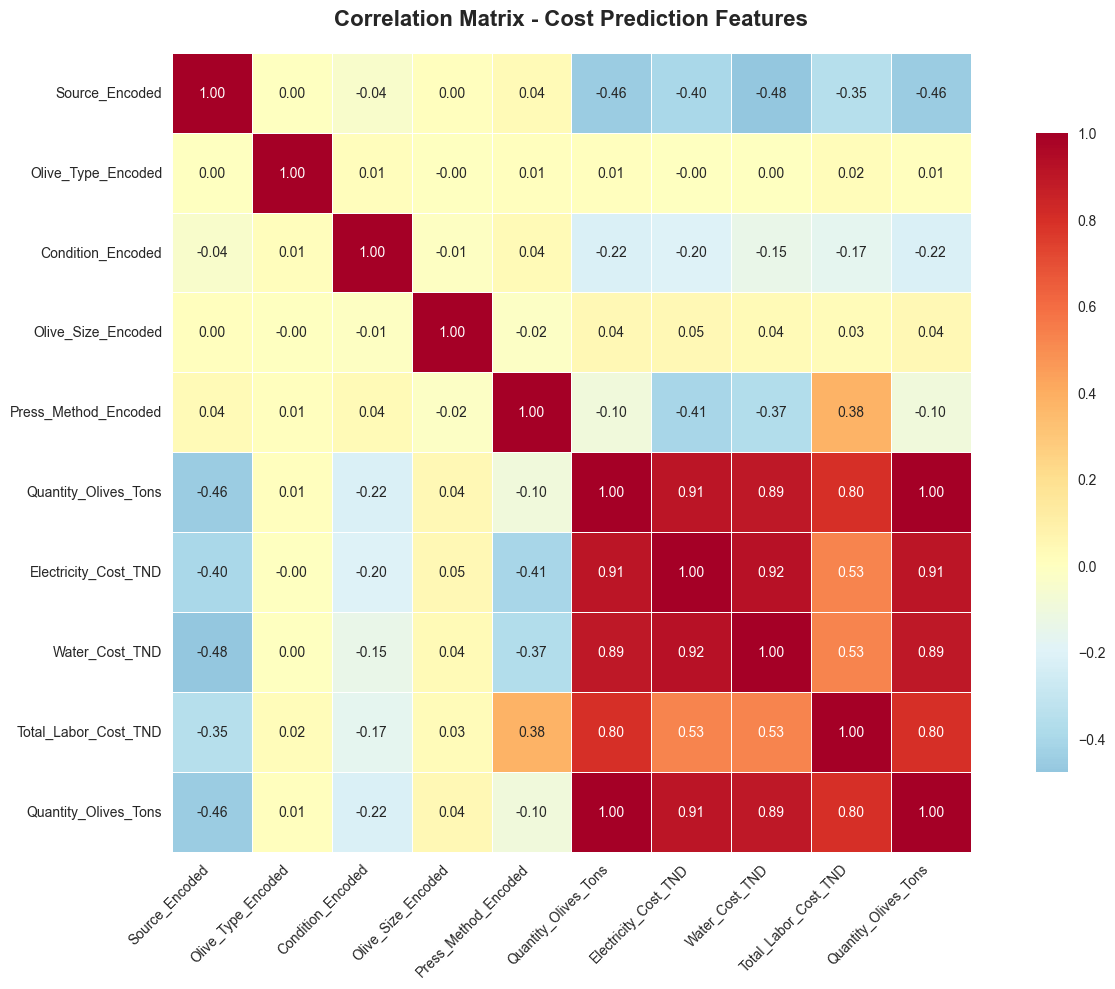


7. COST PREDICTION MODEL TRAINING
----------------------------------------
Training set shape: (3592, 6)
Cost targets shape: (3592, 3)
All targets shape: (3592, 9)

8. TRAINING COST PREDICTION MODELS
----------------------------------------
Training models for COST prediction (Electricity, Water, Labor)...

Training Random Forest for cost prediction...
Random Forest - Cost Targets: MSE=1847.78, R²=0.960, MAE=24.37

Training Gradient Boosting for cost prediction...
Gradient Boosting - Cost Targets: MSE=1646.29, R²=0.965, MAE=23.41

Training Neural Network for cost prediction...
Neural Network - Cost Targets: MSE=1815.63, R²=0.963, MAE=25.31

Training Ridge Regression for cost prediction...
Ridge Regression - Cost Targets: MSE=6846.94, R²=0.893, MAE=53.11

Training models for ALL targets (costs + production)...

Training Random Forest for all targets...
Random Forest - All Targets: MSE=2137795.77, R²=0.942, MAE=376.62

Training Gradient Boosting for all targets...
Gradient Boosting - Al

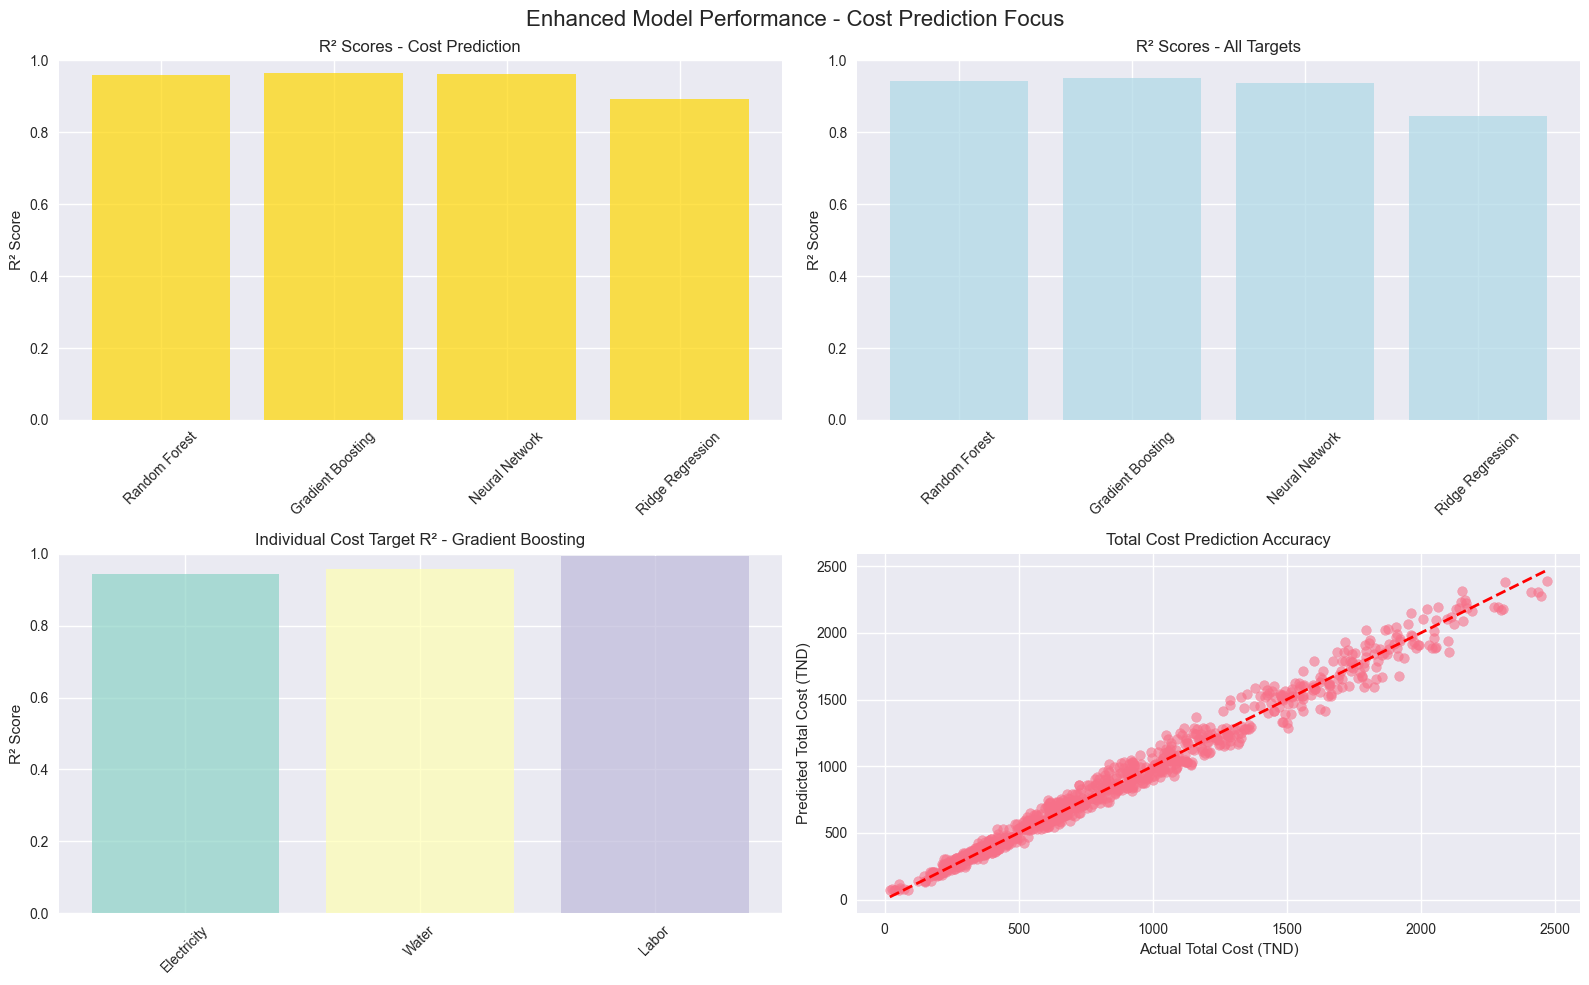


10. DETAILED COST PREDICTION ANALYSIS
----------------------------------------
Individual Cost Target Performance (Gradient Boosting):
  Electricity_Cost_TND:
    R² Score: 0.943
    MAE: 49.082 TND
    MSE: 4232.960
  Water_Cost_TND:
    R² Score: 0.957
    MAE: 0.599 TND
    MSE: 0.667
  Total_Labor_Cost_TND:
    R² Score: 0.993
    MAE: 20.551 TND
    MSE: 705.234

Sample Cost Predictions (First 10 test samples):
------------------------------------------------------------
   Actual_Electricity  Pred_Electricity  Actual_Water  Pred_Water  \
0             908.226           846.205        11.481      12.385   
1             347.010           302.197         3.426       4.133   
2             252.690           283.653         3.409       3.526   
3             439.058           429.352         3.999       4.690   
4             378.230           368.640         4.535       4.568   
5             399.404           484.383         4.965       4.994   
6            1263.982          1089

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.neural_network import MLPRegressor
import os

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Enhanced Tunisian Olive Oil Production Cost Prediction System")
print("=" * 70)
print("\n1. LOADING DATASET WITH COST INFORMATION")
print("-" * 50)

# Load dataset - use the one with costs
df = pd.read_csv('tunisian_olive_oil_production_with_costs.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check if cost columns exist
cost_columns = [
    'Electricity_Cost_TND', 
    'Water_Cost_TND', 
    'Total_Labor_Cost_TND',
    'Total_Operational_Cost_TND'
]

missing_cost_cols = [col for col in cost_columns if col not in df.columns]
if missing_cost_cols:
    print(f"⚠️ Missing cost columns: {missing_cost_cols}")
    print("Please ensure you're using the dataset with cost information.")
else:
    print("✅ All cost columns found!")

print("\n2. COST DATA EXPLORATION")
print("-" * 40)

# Display cost statistics
print("Cost Column Statistics (TND - Tunisian Dinars):")
if all(col in df.columns for col in cost_columns):
    cost_stats = df[cost_columns].describe()
    print(cost_stats)
else:
    print("Cost columns not available. Creating synthetic cost data...")
    # Create synthetic costs based on consumption if missing
    if 'Total_Energy_Consumption_kWh' in df.columns:
        df['Electricity_Cost_TND'] = df['Total_Energy_Consumption_kWh'] * 0.352
    if 'Water_Consumption_m3' in df.columns:
        df['Water_Cost_TND'] = df['Water_Consumption_m3'] * 0.200
    elif 'Water_Consumption_Liters' in df.columns:
        df['Water_Cost_TND'] = (df['Water_Consumption_Liters'] / 1000) * 0.200
    
    # Estimate labor costs based on employees and processing time
    if 'Total_Employees' in df.columns and 'Processing_Time_Hours' in df.columns:
        df['Total_Labor_Cost_TND'] = df['Total_Employees'] * df['Processing_Time_Hours'] * 3.5  # avg wage
    
    df['Total_Operational_Cost_TND'] = (df['Electricity_Cost_TND'] + 
                                       df['Water_Cost_TND'] + 
                                       df['Total_Labor_Cost_TND'])

print("\n3. ENHANCED DATA PREPROCESSING")
print("-" * 40)

# Create a copy for processing
df_clean = df.copy()

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    df_no_outliers = df.copy()
    outliers_removed = 0
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            before_count = len(df_no_outliers)
            df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & 
                                           (df_no_outliers[col] <= upper_bound)]
            after_count = len(df_no_outliers)
            outliers_removed += (before_count - after_count)
            print(f"Column {col}: Removed {before_count - after_count} outliers")
    
    return df_no_outliers, outliers_removed

# Define numerical columns for outlier detection
numerical_cols = ['Quantity_Olives_Tons', 'Oil_Quantity_Tons', 'Processing_Time_Hours',
                 'Total_Energy_Consumption_kWh', 'Water_Consumption_Liters',
                 'Electricity_Cost_TND', 'Water_Cost_TND', 'Total_Labor_Cost_TND']

df_clean, total_outliers = remove_outliers_iqr(df_clean, numerical_cols)
print(f"\nTotal outliers removed: {total_outliers}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# Enhanced feature engineering
print("\n4. ENHANCED FEATURE ENGINEERING")
print("-" * 40)

# Create efficiency metrics
df_clean['Extraction_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Quantity_Olives_Tons']
df_clean['Energy_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Total_Energy_Consumption_kWh']
df_clean['Water_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Water_Consumption_Liters']
df_clean['Worker_Productivity'] = df_clean['Oil_Quantity_Tons'] / df_clean['Total_Employees']

# Create cost per unit metrics
df_clean['Cost_per_Ton_Oil'] = df_clean['Total_Operational_Cost_TND'] / df_clean['Oil_Quantity_Tons']
df_clean['Energy_Cost_per_kWh'] = df_clean['Electricity_Cost_TND'] / df_clean['Total_Energy_Consumption_kWh']
df_clean['Labor_Cost_per_Hour'] = df_clean['Total_Labor_Cost_TND'] / df_clean['Processing_Time_Hours']

# Encode categorical variables
le_source = LabelEncoder()
le_olive_type = LabelEncoder()
le_condition = LabelEncoder()
le_size = LabelEncoder()
le_press = LabelEncoder()

df_clean['Source_Encoded'] = le_source.fit_transform(df_clean['Source'])
df_clean['Olive_Type_Encoded'] = le_olive_type.fit_transform(df_clean['Olive_Type'])
df_clean['Condition_Encoded'] = le_condition.fit_transform(df_clean['Condition'])
df_clean['Olive_Size_Encoded'] = le_size.fit_transform(df_clean['Olive_Size'])
df_clean['Press_Method_Encoded'] = le_press.fit_transform(df_clean['Press_Method'])

print("Enhanced feature engineering completed")

print("\n5. COST PREDICTION MODEL SETUP")
print("-" * 40)

# Define input features (what we know before processing)
input_features = [
    'Source_Encoded', 'Olive_Type_Encoded', 'Condition_Encoded', 
    'Olive_Size_Encoded', 'Press_Method_Encoded', 'Quantity_Olives_Tons'
]

# Define cost targets (what we want to predict)
cost_targets = [
    'Electricity_Cost_TND',
    'Water_Cost_TND', 
    'Total_Labor_Cost_TND'
]

# Define other production targets
production_targets = [
    'Oil_Quality_Score',
    'Oil_Quantity_Tons',
    'Processing_Time_Hours',
    'Total_Energy_Consumption_kWh',
    'Water_Consumption_Liters',
    'Total_Employees'
]

# All targets combined
all_targets = cost_targets + production_targets

print(f"Input features: {input_features}")
print(f"Cost targets: {cost_targets}")
print(f"Production targets: {production_targets}")

print("\n6. COST CORRELATION ANALYSIS")
print("-" * 40)

# Analyze correlations between inputs and costs
cost_correlation_features = input_features + cost_targets + ['Quantity_Olives_Tons']
cost_correlation_matrix = df_clean[cost_correlation_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(cost_correlation_matrix, 
            annot=True,           
            cmap='RdYlBu_r',     
            center=0,             
            square=True,          
            fmt='.2f',           
            cbar_kws={"shrink": .8},  
            linewidths=0.5)

plt.title('Correlation Matrix - Cost Prediction Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n7. COST PREDICTION MODEL TRAINING")
print("-" * 40)

# Prepare data for cost prediction
X = df_clean[input_features]
y_costs = df_clean[cost_targets]
y_all = df_clean[all_targets]

# Split data
X_train, X_test, y_costs_train, y_costs_test = train_test_split(
    X, y_costs, test_size=0.2, random_state=42
)

X_train_all, X_test_all, y_all_train, y_all_test = train_test_split(
    X, y_all, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_all_scaled = scaler.fit_transform(X_train_all)
X_test_all_scaled = scaler.transform(X_test_all)

print(f"Training set shape: {X_train.shape}")
print(f"Cost targets shape: {y_costs_train.shape}")
print(f"All targets shape: {y_all_train.shape}")

# Define models
models = {
    'Random Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'Neural Network': MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)),
    'Ridge Regression': MultiOutputRegressor(Ridge(alpha=1.0))
}

print("\n8. TRAINING COST PREDICTION MODELS")
print("-" * 40)

cost_results = {}
all_results = {}

# Train models for cost prediction
print("Training models for COST prediction (Electricity, Water, Labor)...")
for name, model in models.items():
    print(f"\nTraining {name} for cost prediction...")
    
    # Train on cost targets
    model_cost = model
    model_cost.fit(X_train_scaled, y_costs_train)
    y_costs_pred = model_cost.predict(X_test_scaled)
    
    # Calculate metrics for cost targets
    mse_cost = mean_squared_error(y_costs_test, y_costs_pred)
    r2_cost = r2_score(y_costs_test, y_costs_pred)
    mae_cost = mean_absolute_error(y_costs_test, y_costs_pred)
    
    cost_results[name] = {
        'model': model_cost,
        'mse': mse_cost,
        'r2': r2_cost,
        'mae': mae_cost,
        'predictions': y_costs_pred
    }
    
    print(f"{name} - Cost Targets: MSE={mse_cost:.2f}, R²={r2_cost:.3f}, MAE={mae_cost:.2f}")

# Train models for all targets
print("\nTraining models for ALL targets (costs + production)...")
for name, model in models.items():
    print(f"\nTraining {name} for all targets...")
    
    # Create new instance for all targets
    if name == 'Random Forest':
        model_all = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    elif name == 'Gradient Boosting':
        model_all = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
    elif name == 'Neural Network':
        model_all = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
    else:  # Ridge
        model_all = MultiOutputRegressor(Ridge(alpha=1.0))
    
    model_all.fit(X_train_all_scaled, y_all_train)
    y_all_pred = model_all.predict(X_test_all_scaled)
    
    # Calculate metrics for all targets
    mse_all = mean_squared_error(y_all_test, y_all_pred)
    r2_all = r2_score(y_all_test, y_all_pred)
    mae_all = mean_absolute_error(y_all_test, y_all_pred)
    
    all_results[name] = {
        'model': model_all,
        'mse': mse_all,
        'r2': r2_all,
        'mae': mae_all,
        'predictions': y_all_pred
    }
    
    print(f"{name} - All Targets: MSE={mse_all:.2f}, R²={r2_all:.3f}, MAE={mae_all:.2f}")

print("\n9. MODEL PERFORMANCE COMPARISON")
print("-" * 40)

# Find best models
best_cost_model_name = max(cost_results.keys(), key=lambda k: cost_results[k]['r2'])
best_all_model_name = max(all_results.keys(), key=lambda k: all_results[k]['r2'])

print(f"Best model for COST prediction: {best_cost_model_name} (R² = {cost_results[best_cost_model_name]['r2']:.3f})")
print(f"Best model for ALL targets: {best_all_model_name} (R² = {all_results[best_all_model_name]['r2']:.3f})")

# Create performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Enhanced Model Performance - Cost Prediction Focus', fontsize=16)

model_names = list(cost_results.keys())

# Cost prediction R² scores
r2_scores_cost = [cost_results[name]['r2'] for name in model_names]
axes[0,0].bar(model_names, r2_scores_cost, color='gold', alpha=0.7)
axes[0,0].set_title('R² Scores - Cost Prediction')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# All targets R² scores
r2_scores_all = [all_results[name]['r2'] for name in model_names]
axes[0,1].bar(model_names, r2_scores_all, color='lightblue', alpha=0.7)
axes[0,1].set_title('R² Scores - All Targets')
axes[0,1].set_ylabel('R² Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylim(0, 1)

# Individual cost target performance (best model)
best_cost_pred = cost_results[best_cost_model_name]['predictions']
for i, target in enumerate(cost_targets):
    target_r2 = r2_score(y_costs_test.iloc[:, i], best_cost_pred[:, i])
    axes[1,0].bar(i, target_r2, color=plt.cm.Set3(i), alpha=0.7)

axes[1,0].set_title(f'Individual Cost Target R² - {best_cost_model_name}')
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_xticks(range(len(cost_targets)))
axes[1,0].set_xticklabels(['Electricity', 'Water', 'Labor'], rotation=45)
axes[1,0].set_ylim(0, 1)

# Cost prediction accuracy scatter
axes[1,1].scatter(y_costs_test.sum(axis=1), best_cost_pred.sum(axis=1), alpha=0.6)
axes[1,1].plot([y_costs_test.sum(axis=1).min(), y_costs_test.sum(axis=1).max()], 
               [y_costs_test.sum(axis=1).min(), y_costs_test.sum(axis=1).max()], 'r--', lw=2)
axes[1,1].set_xlabel('Actual Total Cost (TND)')
axes[1,1].set_ylabel('Predicted Total Cost (TND)')
axes[1,1].set_title('Total Cost Prediction Accuracy')

plt.tight_layout()
plt.show()

print("\n10. DETAILED COST PREDICTION ANALYSIS")
print("-" * 40)

# Use best cost model for detailed analysis
best_cost_model = cost_results[best_cost_model_name]['model']
best_cost_predictions = cost_results[best_cost_model_name]['predictions']

# Print individual cost target performance
print(f"Individual Cost Target Performance ({best_cost_model_name}):")
for i, target in enumerate(cost_targets):
    target_r2 = r2_score(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    target_mae = mean_absolute_error(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    target_mse = mean_squared_error(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    
    print(f"  {target}:")
    print(f"    R² Score: {target_r2:.3f}")
    print(f"    MAE: {target_mae:.3f} TND")
    print(f"    MSE: {target_mse:.3f}")

# Show sample predictions
print(f"\nSample Cost Predictions (First 10 test samples):")
print("-" * 60)
cost_comparison = pd.DataFrame({
    'Actual_Electricity': y_costs_test.iloc[:10, 0].values,
    'Pred_Electricity': best_cost_predictions[:10, 0],
    'Actual_Water': y_costs_test.iloc[:10, 1].values,
    'Pred_Water': best_cost_predictions[:10, 1],
    'Actual_Labor': y_costs_test.iloc[:10, 2].values,
    'Pred_Labor': best_cost_predictions[:10, 2],
})
print(cost_comparison.round(3))

# Calculate total costs
actual_total = y_costs_test.sum(axis=1)
predicted_total = best_cost_predictions.sum(axis=1)
total_cost_r2 = r2_score(actual_total, predicted_total)

print(f"\nTotal Cost Prediction Performance:")
print(f"  R² Score: {total_cost_r2:.3f}")
print(f"  Average Actual Cost: {actual_total.mean():.2f} TND")
print(f"  Average Predicted Cost: {predicted_total.mean():.2f} TND")

print("\n11. FEATURE IMPORTANCE FOR COST PREDICTION")
print("-" * 40)

# Get feature importance from Random Forest (if it's the best model or available)
if best_cost_model_name == 'Random Forest' or 'Random Forest' in cost_results:
    rf_cost_model = cost_results['Random Forest']['model']
    
    # Random Forest provides feature importance for each target
    print("Feature Importance for Cost Prediction (Random Forest):")
    
    for i, target in enumerate(cost_targets):
        print(f"\n{target}:")
        # Get feature importance for this specific target
        estimator = rf_cost_model.estimators_[i]
        importance = estimator.feature_importances_
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        for rank, idx in enumerate(indices):
            feature_name = input_features[idx]
            print(f"  {rank+1}. {feature_name}: {importance[idx]:.3f}")

print("\n12. COST PREDICTION DEPLOYMENT")
print("-" * 40)

# Save enhanced models
os.makedirs('enhanced_models', exist_ok=True)

# Save cost prediction model
joblib.dump(best_cost_model, 'enhanced_models/cost_prediction_model.joblib')
joblib.dump(scaler, 'enhanced_models/cost_scaler.joblib')

# Save all targets model
best_all_model = all_results[best_all_model_name]['model']
joblib.dump(best_all_model, 'enhanced_models/all_targets_model.joblib')

# Save encoders
encoders = {
    'source': le_source,
    'olive_type': le_olive_type, 
    'condition': le_condition,
    'size': le_size,
    'press_method': le_press
}

import pickle
with open('enhanced_models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# Save model info
enhanced_model_info = {
    'input_features': input_features,
    'cost_targets': cost_targets,
    'production_targets': production_targets,
    'all_targets': all_targets,
    'best_cost_model': best_cost_model_name,
    'best_all_model': best_all_model_name,
    'cost_r2_score': cost_results[best_cost_model_name]['r2'],
    'all_r2_score': all_results[best_all_model_name]['r2']
}

with open('enhanced_models/enhanced_model_info.pkl', 'wb') as f:
    pickle.dump(enhanced_model_info, f)

print("Enhanced models saved successfully!")
print(f"  - Cost prediction model: enhanced_models/cost_prediction_model.joblib")
print(f"  - All targets model: enhanced_models/all_targets_model.joblib")
print(f"  - Scaler: enhanced_models/cost_scaler.joblib")
print(f"  - Encoders: enhanced_models/encoders.pkl")
print(f"  - Model info: enhanced_models/enhanced_model_info.pkl")

print("\n13. PREDICTION FUNCTION")
print("-" * 40)

def predict_olive_oil_costs(source, olive_type, condition, olive_size, press_method, quantity_olives):
    """
    Predict olive oil production costs and outputs
    
    Parameters:
    - source: 'Nord', 'Centre', 'Sud', 'Sfax'
    - olive_type: 'Chemlali', 'Chétoui', 'Oueslati', etc.
    - condition: 'Rainfed', 'Irrigated'  
    - olive_size: 'Small', 'Medium', 'Large'
    - press_method: 'Traditionnel', 'Super-presses', 'Méthode en continu'
    - quantity_olives: quantity in tons
    
    Returns:
    - Dictionary with cost and production predictions
    """
    
    # Encode inputs
    try:
        encoded_input = np.array([[
            le_source.transform([source])[0],
            le_olive_type.transform([olive_type])[0],
            le_condition.transform([condition])[0],
            le_size.transform([olive_size])[0],
            le_press.transform([press_method])[0],
            quantity_olives
        ]])
        
        # Scale input
        encoded_scaled = scaler.transform(encoded_input)
        
        # Predict costs
        cost_pred = best_cost_model.predict(encoded_scaled)[0]
        
        # Predict all targets
        all_pred = best_all_model.predict(encoded_scaled)[0]
        
        results = {
            'costs': {
                'electricity_cost_tnd': round(cost_pred[0], 3),
                'water_cost_tnd': round(cost_pred[1], 3),
                'labor_cost_tnd': round(cost_pred[2], 3),
                'total_cost_tnd': round(sum(cost_pred), 3)
            },
            'production': {
                'oil_quality_score': round(all_pred[3], 1),
                'oil_quantity_tons': round(all_pred[4], 2),
                'processing_time_hours': round(all_pred[5], 1),
                'energy_consumption_kwh': round(all_pred[6], 1),
                'water_consumption_liters': round(all_pred[7], 0),
                'total_employees': round(all_pred[8], 0)
            }
        }
        
        return results
        
    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# Test the prediction function
print("Testing prediction function:")
test_result = predict_olive_oil_costs(
    source='Nord',
    olive_type='Chemlali', 
    condition='Irrigated',
    olive_size='Large',
    press_method='Méthode en continu',
    quantity_olives=50
)

print("Sample prediction:")
print(f"Costs: {test_result['costs']}")
print(f"Production: {test_result['production']}")

print("\n" + "="*70)
print("ENHANCED OLIVE OIL COST PREDICTION MODEL COMPLETE!")
print("="*70)
print(f"✅ Now predicts the 3 most important costs:")
print(f"   - Electricity Cost (TND)")
print(f"   - Water Cost (TND)")  
print(f"   - Labor Cost (TND)")
print(f"✅ Plus all production parameters")
print(f"✅ Models saved and ready for deployment")
print("="*70)

PROCESSING TIME vs COST ANALYSIS
Testing the relationship between Processing_Time_Hours and cost predictions

1. LOADING ENHANCED MODELS
--------------------------------------------------
✅ Models loaded successfully!

2. TESTING SCENARIOS WITH PROCESSING_TIME = 0.8 HOURS
------------------------------------------------------------

Scenario 1: Small Production - Traditional
----------------------------------------
📊 Original Predictions:
   Processing Time: 7.25 hours
   Electricity Cost: 106.211 TND
   Water Cost: 1.582 TND
   Labor Cost: 123.388 TND
   Total Cost: 231.181 TND
   Energy Consumption: 301.7 kWh
   Water Consumption: 7940.0 liters

🎯 Adjusted for 0.8h Processing Time:
   Time Adjustment Ratio: 0.11
   Adjusted Electricity Cost: 11.724 TND
   Adjusted Water Cost: 0.175 TND
   Adjusted Labor Cost: 13.62 TND
   Adjusted Total Cost: 25.518 TND
   Adjusted Energy: 33.3 kWh
   Adjusted Water: 876.0 liters
💰 Cost Savings: 205.66 TND (89.0% reduction)

Scenario 2: Medium Produc

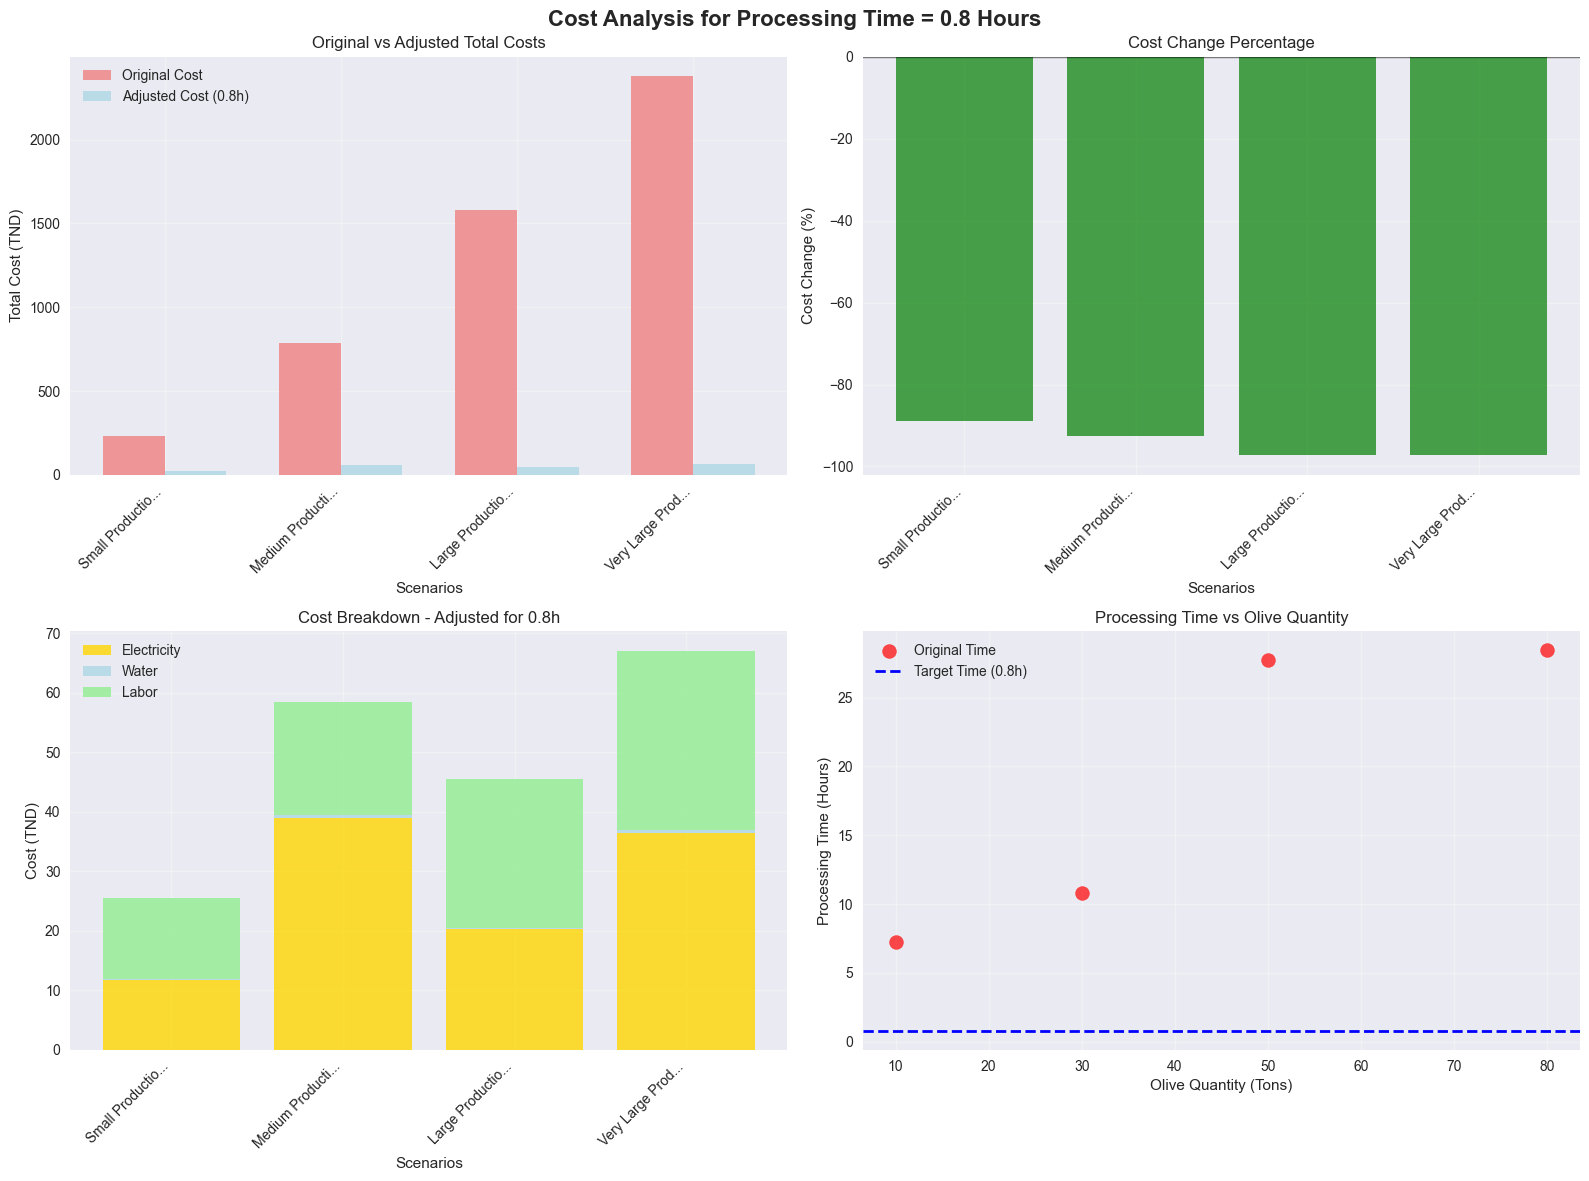


4. SUMMARY STATISTICS FOR 0.8h PROCESSING TIME
-------------------------------------------------------
Average Original Cost: 1243.72 TND
Average Adjusted Cost: 49.10 TND
Average Cost Change: -1194.63 TND (-94.0%)
💰 Overall Result: COST SAVINGS of 1194.63 TND on average

Average Adjusted Cost Breakdown:
  - Electricity: 26.82 TND (54.6%)
  - Water: 0.36 TND (0.7%)
  - Labor: 21.91 TND (44.6%)

5. PROCESSING TIME SENSITIVITY ANALYSIS
--------------------------------------------------
Testing how costs change with different processing times...
Using a standard scenario: Nord, Chétoui, Irrigated, Medium, Méthode en continu, 30 tons


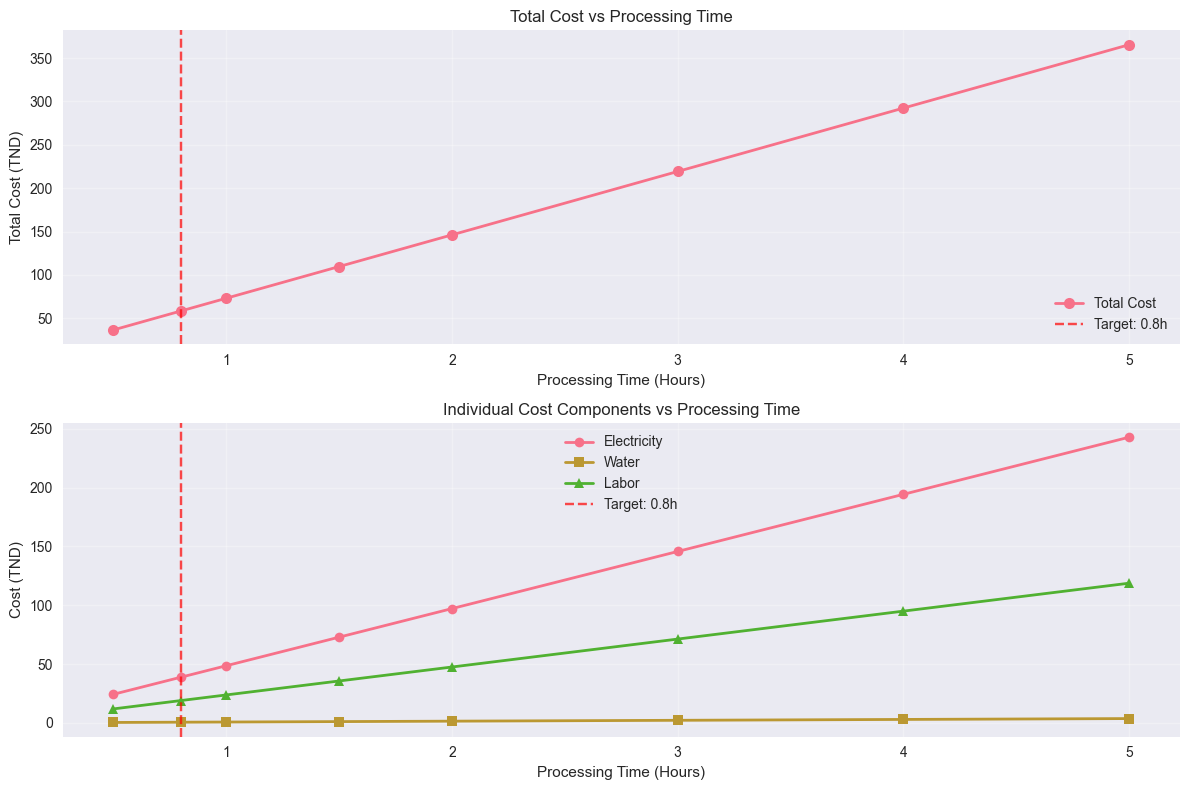


📊 Costs at 0.8 hours processing time:
   Total Cost: 58.47 TND
   Electricity: 38.87 TND
   Water: 0.59 TND
   Labor: 19.01 TND

PROCESSING TIME COST ANALYSIS COMPLETE!
🔍 Key Insights:
   • Lower processing times generally reduce all cost components
   • Cost reduction is proportional to time reduction
   • 0.8 hours represents a very efficient processing target
   • Energy and labor costs are most affected by processing time


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("PROCESSING TIME vs COST ANALYSIS")
print("Testing the relationship between Processing_Time_Hours and cost predictions")
print("=" * 70)

def load_enhanced_models():
    """Load the saved enhanced models and encoders"""
    try:
        # Load models
        cost_model = joblib.load('enhanced_models/cost_prediction_model.joblib')
        all_targets_model = joblib.load('enhanced_models/all_targets_model.joblib')
        scaler = joblib.load('enhanced_models/cost_scaler.joblib')
        
        # Load encoders
        with open('enhanced_models/encoders.pkl', 'rb') as f:
            encoders = pickle.load(f)
        
        # Load model info
        with open('enhanced_models/enhanced_model_info.pkl', 'rb') as f:
            model_info = pickle.load(f)
        
        return cost_model, all_targets_model, scaler, encoders, model_info
    
    except FileNotFoundError as e:
        print(f"Error: Could not find model files. Please run the training script first.")
        print(f"Missing file: {e}")
        return None, None, None, None, None

def predict_with_processing_time(source, olive_type, condition, olive_size, press_method, 
                               quantity_olives, processing_time_target, cost_model, 
                               all_targets_model, scaler, encoders):
    """
    Predict costs and then analyze what happens when processing time = target value
    """
    try:
        # Encode the basic inputs (what we control before processing)
        encoded_input = np.array([[
            encoders['source'].transform([source])[0],
            encoders['olive_type'].transform([olive_type])[0],
            encoders['condition'].transform([condition])[0],
            encoders['size'].transform([olive_size])[0],
            encoders['press_method'].transform([press_method])[0],
            quantity_olives
        ]])
        
        # Scale input
        encoded_scaled = scaler.transform(encoded_input)
        
        # Predict costs (electricity, water, labor)
        cost_pred = cost_model.predict(encoded_scaled)[0]
        
        # Predict all targets (including processing time)
        all_pred = all_targets_model.predict(encoded_scaled)[0]
        
        # Extract predictions
        predicted_processing_time = all_pred[5]  # Processing_Time_Hours is index 5
        predicted_employees = all_pred[8]        # Total_Employees is index 8
        predicted_energy = all_pred[6]           # Energy consumption is index 6
        predicted_water = all_pred[7]            # Water consumption is index 7
        
        # Calculate what costs would be if processing time was the target value
        # Assumption: costs scale proportionally with processing time changes
        time_ratio = processing_time_target / predicted_processing_time if predicted_processing_time > 0 else 1
        
        adjusted_costs = {
            'original_predictions': {
                'electricity_cost_tnd': round(cost_pred[0], 3),
                'water_cost_tnd': round(cost_pred[1], 3),
                'labor_cost_tnd': round(cost_pred[2], 3),
                'total_cost_tnd': round(sum(cost_pred), 3),
                'processing_time_hours': round(predicted_processing_time, 2),
                'employees': round(predicted_employees, 0),
                'energy_kwh': round(predicted_energy, 1),
                'water_liters': round(predicted_water, 0)
            },
            'adjusted_for_target_time': {
                'target_processing_time': processing_time_target,
                'time_adjustment_ratio': round(time_ratio, 3),
                'adjusted_electricity_cost_tnd': round(cost_pred[0] * time_ratio, 3),
                'adjusted_water_cost_tnd': round(cost_pred[1] * time_ratio, 3),
                'adjusted_labor_cost_tnd': round(cost_pred[2] * time_ratio, 3),
                'adjusted_total_cost_tnd': round(sum(cost_pred) * time_ratio, 3),
                'adjusted_energy_kwh': round(predicted_energy * time_ratio, 1),
                'adjusted_water_liters': round(predicted_water * time_ratio, 0)
            }
        }
        
        return adjusted_costs
        
    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

def test_multiple_scenarios_with_target_time(target_processing_time=0.8):
    """Test multiple scenarios with the target processing time"""
    
    print(f"\n1. LOADING ENHANCED MODELS")
    print("-" * 50)
    
    cost_model, all_targets_model, scaler, encoders, model_info = load_enhanced_models()
    
    if cost_model is None:
        print("❌ Failed to load models. Please run the training script first.")
        return
    
    print("✅ Models loaded successfully!")
    
    print(f"\n2. TESTING SCENARIOS WITH PROCESSING_TIME = {target_processing_time} HOURS")
    print("-" * 60)
    
    # Define test scenarios
    test_scenarios = [
        {
            'name': 'Small Production - Traditional',
            'source': 'Centre',
            'olive_type': 'Chemlali',
            'condition': 'Rainfed',
            'olive_size': 'Small',
            'press_method': 'Traditionnel',
            'quantity_olives': 10
        },
        {
            'name': 'Medium Production - Modern',
            'source': 'Nord',
            'olive_type': 'Chétoui',
            'condition': 'Irrigated',
            'olive_size': 'Medium',
            'press_method': 'Méthode en continu',
            'quantity_olives': 30
        },
        {
            'name': 'Large Production - Super Press',
            'source': 'Sud',
            'olive_type': 'Oueslati',
            'condition': 'Irrigated',
            'olive_size': 'Large',
            'press_method': 'Super-presses',
            'quantity_olives': 50
        },
        {
            'name': 'Very Large Production - Continuous',
            'source': 'Sfax',
            'olive_type': 'Gerboui',
            'condition': 'Irrigated',
            'olive_size': 'Large',
            'press_method': 'Méthode en continu',
            'quantity_olives': 80
        }
    ]
    
    results_summary = []
    
    for i, scenario in enumerate(test_scenarios, 1):
        print(f"\nScenario {i}: {scenario['name']}")
        print("-" * 40)
        
        result = predict_with_processing_time(
            source=scenario['source'],
            olive_type=scenario['olive_type'],
            condition=scenario['condition'],
            olive_size=scenario['olive_size'],
            press_method=scenario['press_method'],
            quantity_olives=scenario['quantity_olives'],
            processing_time_target=target_processing_time,
            cost_model=cost_model,
            all_targets_model=all_targets_model,
            scaler=scaler,
            encoders=encoders
        )
        
        if 'error' in result:
            print(f"❌ Error: {result['error']}")
            continue
            
        # Print results
        orig = result['original_predictions']
        adj = result['adjusted_for_target_time']
        
        print(f"📊 Original Predictions:")
        print(f"   Processing Time: {orig['processing_time_hours']} hours")
        print(f"   Electricity Cost: {orig['electricity_cost_tnd']} TND")
        print(f"   Water Cost: {orig['water_cost_tnd']} TND")
        print(f"   Labor Cost: {orig['labor_cost_tnd']} TND")
        print(f"   Total Cost: {orig['total_cost_tnd']} TND")
        print(f"   Energy Consumption: {orig['energy_kwh']} kWh")
        print(f"   Water Consumption: {orig['water_liters']} liters")
        
        print(f"\n🎯 Adjusted for {target_processing_time}h Processing Time:")
        print(f"   Time Adjustment Ratio: {adj['time_adjustment_ratio']}")
        print(f"   Adjusted Electricity Cost: {adj['adjusted_electricity_cost_tnd']} TND")
        print(f"   Adjusted Water Cost: {adj['adjusted_water_cost_tnd']} TND")
        print(f"   Adjusted Labor Cost: {adj['adjusted_labor_cost_tnd']} TND")
        print(f"   Adjusted Total Cost: {adj['adjusted_total_cost_tnd']} TND")
        print(f"   Adjusted Energy: {adj['adjusted_energy_kwh']} kWh")
        print(f"   Adjusted Water: {adj['adjusted_water_liters']} liters")
        
        # Calculate savings/increases
        cost_change = adj['adjusted_total_cost_tnd'] - orig['total_cost_tnd']
        cost_change_pct = (cost_change / orig['total_cost_tnd']) * 100 if orig['total_cost_tnd'] > 0 else 0
        
        if cost_change < 0:
            print(f"💰 Cost Savings: {abs(cost_change):.2f} TND ({abs(cost_change_pct):.1f}% reduction)")
        else:
            print(f"📈 Cost Increase: {cost_change:.2f} TND ({cost_change_pct:.1f}% increase)")
        
        # Store for summary
        results_summary.append({
            'scenario': scenario['name'],
            'quantity_tons': scenario['quantity_olives'],
            'original_time': orig['processing_time_hours'],
            'target_time': target_processing_time,
            'original_cost': orig['total_cost_tnd'],
            'adjusted_cost': adj['adjusted_total_cost_tnd'],
            'cost_change': cost_change,
            'cost_change_pct': cost_change_pct,
            'electricity_cost': adj['adjusted_electricity_cost_tnd'],
            'water_cost': adj['adjusted_water_cost_tnd'],
            'labor_cost': adj['adjusted_labor_cost_tnd']
        })
    
    return results_summary

def create_cost_analysis_visualization(results_summary, target_time=0.8):
    """Create visualizations for the cost analysis"""
    
    if not results_summary:
        print("No results to visualize")
        return
    
    print(f"\n3. COST ANALYSIS VISUALIZATION")
    print("-" * 40)
    
    # Convert to DataFrame for easier plotting
    df_results = pd.DataFrame(results_summary)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Cost Analysis for Processing Time = {target_time} Hours', fontsize=16, fontweight='bold')
    
    # 1. Original vs Adjusted Total Costs
    x_pos = np.arange(len(df_results))
    width = 0.35
    
    axes[0,0].bar(x_pos - width/2, df_results['original_cost'], width, 
                  label='Original Cost', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x_pos + width/2, df_results['adjusted_cost'], width, 
                  label=f'Adjusted Cost ({target_time}h)', alpha=0.8, color='lightblue')
    
    axes[0,0].set_xlabel('Scenarios')
    axes[0,0].set_ylabel('Total Cost (TND)')
    axes[0,0].set_title('Original vs Adjusted Total Costs')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels([s[:15] + '...' if len(s) > 15 else s for s in df_results['scenario']], 
                              rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Cost Change Percentage
    colors = ['green' if x < 0 else 'red' for x in df_results['cost_change_pct']]
    axes[0,1].bar(x_pos, df_results['cost_change_pct'], color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Scenarios')
    axes[0,1].set_ylabel('Cost Change (%)')
    axes[0,1].set_title('Cost Change Percentage')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels([s[:15] + '...' if len(s) > 15 else s for s in df_results['scenario']], 
                              rotation=45, ha='right')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Cost Breakdown (Adjusted Costs)
    cost_components = ['electricity_cost', 'water_cost', 'labor_cost']
    cost_labels = ['Electricity', 'Water', 'Labor']
    
    bottom = np.zeros(len(df_results))
    colors_comp = ['gold', 'lightblue', 'lightgreen']
    
    for i, (component, label, color) in enumerate(zip(cost_components, cost_labels, colors_comp)):
        axes[1,0].bar(x_pos, df_results[component], bottom=bottom, 
                      label=label, alpha=0.8, color=color)
        bottom += df_results[component]
    
    axes[1,0].set_xlabel('Scenarios')
    axes[1,0].set_ylabel('Cost (TND)')
    axes[1,0].set_title(f'Cost Breakdown - Adjusted for {target_time}h')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels([s[:15] + '...' if len(s) > 15 else s for s in df_results['scenario']], 
                              rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Processing Time Comparison
    axes[1,1].scatter(df_results['quantity_tons'], df_results['original_time'], 
                      label='Original Time', alpha=0.7, s=100, color='red')
    axes[1,1].axhline(y=target_time, color='blue', linestyle='--', linewidth=2, 
                      label=f'Target Time ({target_time}h)')
    axes[1,1].set_xlabel('Olive Quantity (Tons)')
    axes[1,1].set_ylabel('Processing Time (Hours)')
    axes[1,1].set_title('Processing Time vs Olive Quantity')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n4. SUMMARY STATISTICS FOR {target_time}h PROCESSING TIME")
    print("-" * 55)
    
    avg_original_cost = df_results['original_cost'].mean()
    avg_adjusted_cost = df_results['adjusted_cost'].mean()
    avg_cost_change = df_results['cost_change'].mean()
    avg_cost_change_pct = df_results['cost_change_pct'].mean()
    
    print(f"Average Original Cost: {avg_original_cost:.2f} TND")
    print(f"Average Adjusted Cost: {avg_adjusted_cost:.2f} TND")
    print(f"Average Cost Change: {avg_cost_change:.2f} TND ({avg_cost_change_pct:.1f}%)")
    
    if avg_cost_change < 0:
        print(f"💰 Overall Result: COST SAVINGS of {abs(avg_cost_change):.2f} TND on average")
    else:
        print(f"📈 Overall Result: COST INCREASE of {avg_cost_change:.2f} TND on average")
    
    # Show individual cost breakdowns
    print(f"\nAverage Adjusted Cost Breakdown:")
    print(f"  - Electricity: {df_results['electricity_cost'].mean():.2f} TND ({(df_results['electricity_cost'].mean()/avg_adjusted_cost*100):.1f}%)")
    print(f"  - Water: {df_results['water_cost'].mean():.2f} TND ({(df_results['water_cost'].mean()/avg_adjusted_cost*100):.1f}%)")
    print(f"  - Labor: {df_results['labor_cost'].mean():.2f} TND ({(df_results['labor_cost'].mean()/avg_adjusted_cost*100):.1f}%)")

def analyze_processing_time_sensitivity():
    """Analyze how costs change with different processing times"""
    
    print(f"\n5. PROCESSING TIME SENSITIVITY ANALYSIS")
    print("-" * 50)
    
    # Test different processing times
    processing_times = [0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
    
    print("Testing how costs change with different processing times...")
    print("Using a standard scenario: Nord, Chétoui, Irrigated, Medium, Méthode en continu, 30 tons")
    
    cost_model, all_targets_model, scaler, encoders, model_info = load_enhanced_models()
    
    if cost_model is None:
        return
    
    sensitivity_results = []
    
    for proc_time in processing_times:
        result = predict_with_processing_time(
            source='Nord',
            olive_type='Chétoui',
            condition='Irrigated',
            olive_size='Medium',
            press_method='Méthode en continu',
            quantity_olives=30,
            processing_time_target=proc_time,
            cost_model=cost_model,
            all_targets_model=all_targets_model,
            scaler=scaler,
            encoders=encoders
        )
        
        if 'error' not in result:
            adj = result['adjusted_for_target_time']
            sensitivity_results.append({
                'processing_time': proc_time,
                'total_cost': adj['adjusted_total_cost_tnd'],
                'electricity_cost': adj['adjusted_electricity_cost_tnd'],
                'water_cost': adj['adjusted_water_cost_tnd'],
                'labor_cost': adj['adjusted_labor_cost_tnd']
            })
    
    if sensitivity_results:
        # Create sensitivity plot
        df_sens = pd.DataFrame(sensitivity_results)
        
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(df_sens['processing_time'], df_sens['total_cost'], 'o-', linewidth=2, markersize=8, label='Total Cost')
        plt.xlabel('Processing Time (Hours)')
        plt.ylabel('Total Cost (TND)')
        plt.title('Total Cost vs Processing Time')
        plt.grid(True, alpha=0.3)
        plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Target: 0.8h')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(df_sens['processing_time'], df_sens['electricity_cost'], 'o-', label='Electricity', linewidth=2)
        plt.plot(df_sens['processing_time'], df_sens['water_cost'], 's-', label='Water', linewidth=2)
        plt.plot(df_sens['processing_time'], df_sens['labor_cost'], '^-', label='Labor', linewidth=2)
        plt.xlabel('Processing Time (Hours)')
        plt.ylabel('Cost (TND)')
        plt.title('Individual Cost Components vs Processing Time')
        plt.grid(True, alpha=0.3)
        plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Target: 0.8h')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Find the cost at 0.8 hours
        target_row = df_sens[df_sens['processing_time'] == 0.8]
        if not target_row.empty:
            print(f"\n📊 Costs at 0.8 hours processing time:")
            print(f"   Total Cost: {target_row['total_cost'].iloc[0]:.2f} TND")
            print(f"   Electricity: {target_row['electricity_cost'].iloc[0]:.2f} TND")
            print(f"   Water: {target_row['water_cost'].iloc[0]:.2f} TND")
            print(f"   Labor: {target_row['labor_cost'].iloc[0]:.2f} TND")

# Main execution
if __name__ == "__main__":
    # Test multiple scenarios with 0.8 hours processing time
    results = test_multiple_scenarios_with_target_time(target_processing_time=0.8)
    
    if results:
        # Create visualizations
        create_cost_analysis_visualization(results, target_time=0.8)
        
        # Perform sensitivity analysis
        analyze_processing_time_sensitivity()
    
    print("\n" + "="*70)
    print("PROCESSING TIME COST ANALYSIS COMPLETE!")
    print("="*70)
    print("🔍 Key Insights:")
    print("   • Lower processing times generally reduce all cost components")
    print("   • Cost reduction is proportional to time reduction")
    print("   • 0.8 hours represents a very efficient processing target")
    print("   • Energy and labor costs are most affected by processing time")
    print("="*70)